# FAKHRE-EDDINE MOHAMED AMINE - ZAOUI HANANE - EL GHAZI LOUBNA

Pour ce projet, nous allons utiliser l'algorithme XGBoost et l'algorithme Naive Bayes pour classer les données de l'ensemble de validation.

Nous allons comparer les resultats obtenus avec notre algorithme avec ceux obtenus avec l'algorithme Naive Bayes de sklearn.

XGBoost et Naive bayes sont utilisés pour les questions d'apprentissage supervisé dans lesquelles nous prédisons une variable cible $y_i$ en utilisant des données d'apprentissage $x_i$ (avec de nombreuses caractéristiques). Avant d'aborder les spécificités des arbres, passons en revue les principes fondamentaux de l'apprentissage supervisé.

Pour les comprendre, vous devez d'abord comprendre les idées et les méthodes d'apprentissage automatique sur lesquelles il est basé : l'apprentissage automatique supervisé.

Les concepts que nous allons aborder ici sont fondamentaux pour l'apprentissage supervisé et servent de blocs de construction naturels pour les boîtes à outils d'apprentissage automatique. Vous devriez être en mesure de définir les différences et les similitudes entre les arbres boostés par le gradient et les forêts aléatoires, par exemple. Comprendre le processus d'une manière formalisée nous aide également à comprendre l'objectif que nous apprenons ainsi que le raisonnement derrière les heuristiques telles que l'élagage et le lissage.

# **Apprentissage supervisé**
### **Modèle et paramètres**
Supervised learning refers to the mathematical framework used to form predictions from input data. A linear model is a popular example, with the prediction value being $\hat{y}_i = \sum_j \theta_j x_{ij}$. The prediction value can have various meanings, such as logistic conversion for positive class likelihood or ranking score for output ratings. Parameters, the unknowns learned from data, are the coefficients theta in linear regression issues. The description of parameters is sloppy due to the numerous parameters in a model.

### **Fonction objective : Perte d'entraînement + régularisation**
Les sélections prudentes de $y_i$ peuvent être utilisées pour des tâches telles que la régression, la classification et le classement. La formation d'un modèle implique de trouver les paramètres optimaux $\theta$ pour les données de formation $x_i$ et les étiquettes $y_i$. Pour former le modèle, une fonction objective est établie, qui mesure l'adéquation du modèle aux données d'apprentissage. Les fonctions objectives se composent d'une perte d'apprentissage et d'un terme de régularisation:

$\text{obj}(\theta) = L(\theta) + \Omega(\theta)$

où $L$ représente la fonction de perte d'apprentissage et $\Omega$ représente le terme de régularisation. La perte d'apprentissage quantifie le degré de prédiction de notre modèle par rapport aux données d'apprentissage. Une option populaire pour $L$ est l'erreur quadratique moyenne, qui est donnée par :

$L(\theta) = \sum_i (y_i-\hat{y}_i)^2$

Une autre fonction de perte couramment utilisée est la perte logistique, utilisée pour la régression logistique :

$L(\theta) = \sum_i[ y_i\ln (1+e^{-\hat{y}_i}) + (1-y_i)\ln (1+e^{\hat{y}_i})]$

L'expression "régularisation" est souvent négligée. Le terme de régularisation régule la complexité du modèle, ce qui permet d'éviter l'ajustement excessif.

# **Naive Bayes**
### **Principe du classificateur Naive Bayes :**
Un classificateur Naive Bayes est un modèle d'apprentissage automatique probabiliste utilisé pour les tâches de classification. Le cœur du classificateur est basé sur le théorème de Bayes.

### **Théorème de Bayes :**
$P(A|B) = \frac{P(B|A) P(A)}{P(B)}$

En utilisant le théorème de Bayes, nous pouvons trouver la probabilité que A se produise, étant donné que B s'est produit. Ici, B est la preuve et A est l'hypothèse. L'hypothèse faite ici est que les prédicteurs/caractéristiques sont indépendants. En d'autres termes, la présence d'une caractéristique particulière n'affecte pas l'autre. C'est pourquoi cette méthode est qualifiée de naïve.

Le théorème de Bayes peut être réécrit comme suit :
$P(w_i|X) = \frac{P(X|w_i) P(w_i)}{P(X)}$

X est donné comme suit:
$X = (x_1, x_2, \cdots, x_n)$

$P(w_j|X) = \frac{P(X|w_j) P(w_j)}{P(X)} = \frac{P(X|w_j) P(w_j)}{\sum_{i=1}^C P(X|w_i) P(w_i)}$

En supposant que les varaibles sont indepentantes, nous pouvons réécrire l'équation comme suit : \
$P(X|w_j) = \prod_{i=1}^N P(x_i|w_j)$

##### **Types de classificateurs Naive Bayes :**
###### Multinomial Naive Bayes : 
Cette méthode est couramment utilisée pour les problèmes de classification de documents, par exemple pour déterminer si un document appartient aux catégories sport, politique ou technologie. Le classificateur utilise la fréquence des termes dans le document comme caractéristiques/prédicteurs.

###### Bernoulli Naive Bayes : 
Comme le multinomial Naive Bayes, sauf que les prédicteurs sont des variables booléennes. Les paramètres que nous utilisons pour prévoir la variable de classe n'acceptent que des réponses oui ou non, par exemple si un mot apparaît ou non dans le texte.

###### Bayes naïf gaussien : 
Lorsque les prédicteurs sont continus et non discrets, nous supposons qu'ils sont tirés d'une distribution gaussienne. \
$P(x_i|w_j) = {\frac{1}{\sigma_j \sqrt {2\pi}} e^{-\frac{(x_i - \mu_j)^2}{2{\sigma_j}^2}\\$

La probabilité d'une classe est calculée comme suit : \
$P(X|w_j) = \prod_{i=1}^N P(x_i|w_j) = \prod_{i=1}^N {\frac{1}{\sigma_j \sqrt {2\pi}} e^{-\frac{(x_i - \mu_j)^2}{2{\sigma_j}^2}$

# **Extreme Gradient Boosting (XGBoost)**
### **Decision trees (arbres de decision)**
L’apprentissage de l’arbre des décisions est une méthode d’enseignement supervisé qui est utilisée dans les statistiques, l’exploitation minière de données et le machine learning . Il s’agit d’une approche non paramétrique qui peut être utilisée pour la classification ainsi que pour la régression. Le but de l'utilisation d'un arbre décisionnel est d'apprendre les règles de décision de base déduites des attributs de données pour produire un modèle de formation qui peut être utilisé pour prédire la classe ou la valeur de la variable cible.

### **Gradient Boosting Decision Trees (GBDT)**
Gradient Boosting Decision Trees (GBDT) sont une approche d'apprentissage d'ensemble d'arbres de décision pour la classification et la régression qui est comparable au Random forest. Pour créer un meilleur modèle, les techniques d'apprentissage d'ensemble mélangent différentes méthodes d'apprentissage automatique.

Random forest et le GBDT construisent tous deux un modèle à partir de plusieurs arbres de décision. La différence réside dans la manière dont les arbres sont construits et reliés.

Random forest construit des arbres de décision entiers en parallèle à l'aide d'échantillons bootstrap aléatoires de l'ensemble de données, selon un processus connu sous le nom de "bagging". La prévision finale est une moyenne pondérée de toutes les prédictions des arbres de décision. Mathématiquement, nous pouvons écrire notre modèle sous la forme suivante :

$\hat{y}_i = \sum_{k=1}^K f_k(x_i), f_k \in \mathcal{F}$

où $K$ est le nombre d'arbres, $f_k$ est une fonction dans l'espace fonctionnel $\mathcal{F}$, et $\mathcal{F}$ est l'ensemble de tous les CART possibles. La fonction objective à optimiser est donnée par la formule suivante:

$\text{obj}(\theta) = \sum_i^n l(y_i, \hat{y}_i) + \sum_{k=1}^K \omega(f_k)$

où $\omega(f_k)$ est la complexité de l'arbre $f_k$, définie en détail plus loin.

### **Tree Boosting**
L'expression "gradient boosting" est dérivée du concept de "boosting" ou d'amélioration d'un modèle faible unique en le fusionnant avec un certain nombre de modèles faibles supplémentaires pour former un modèle collectivement fort. Le "gradient boosting" est une extension du "boosting" dans laquelle le processus de production additive de modèles faibles est formalisé sous la forme d'un algorithme de descente de gradient sur une fonction objective. L'amplification par gradient cible les résultats du modèle suivant afin de réduire les erreurs. Les résultats ciblés pour chaque instance sont déterminés par le gradient de l'erreur par rapport à la prédiction (d'où le nom de "gradient boosting").

Les GBDT forment un ensemble d'arbres de décision peu profonds de manière répétée, chaque itération utilisant les résidus d'erreur du modèle précédent pour ajuster le modèle suivant. La prévision finale est la moyenne pondérée de toutes les prédictions des arbres. Le "bagging" des forêts aléatoires réduit la variance et le surajustement, tandis que le "boosting" des GBDT réduit le biais et le sous-ajustement.

XGBoost est une solution de gradient boosting évolutive et très précise qui repousse les limites de la puissance de traitement pour les algorithmes d'arbres boostés. Il a été conçu principalement pour améliorer les performances des modèles d'apprentissage automatique et la vitesse de calcul. Les arbres sont construits en parallèle avec XGBoost plutôt que séquentiellement comme avec GBDT. Il utilise une technique par niveau, en balayant les valeurs de gradient et en évaluant la qualité des divisions à chaque division potentielle de l'ensemble d'apprentissage à l'aide de ces sommes partielles.

Maintenant que nous avons établi le modèle, passons à la formation : Comment devons-nous enseigner aux arbres ? La réponse, comme pour tout modèle d'apprentissage supervisé, consiste à créer une fonction objective et à l'optimiser !

Supposons que la fonction objective soit la suivante (notez qu'elle doit toujours inclure la perte d'apprentissage et la régularisation) :

$\text{obj} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\omega(f_i)$

Les paramètres des arbres sont déterminés par les fonctions $f_i$, qui comprennent la structure de l'arbre et les scores des feuilles. L'apprentissage de la structure des arbres est plus difficile que les problèmes d'optimisation traditionnels. Au lieu de cela, une technique additive est employée, en ajoutant un nouvel arbre à la fois. La valeur prévisionnelle s'écrit alors $\hat{y}_i^{(t)}$.

$\hat{y}_i^{(0)} = 0\\
\hat{y}_i^{(1)} = f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} = f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
\\
\dots\\
\hat{y}_i^{(t)} = \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)$

Il faut voir quel arbre nous désirons à chaque étape. Il est naturel d'inclure celui qui permet le mieux d'atteindre notre objectif.

$\text{obj}^{(t)} = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t)}) + \sum_{i=1}^t\omega(f_i) \\
                = \sum_{i=1}^n l(y_i, \hat{y}_i^{(t-1)} + f_t(x_i)) + \omega(f_t) + \mathrm{constant}$
                
Si nous utilisons l'erreur quadratique moyenne (MSE) comme fonction de perte, l'objectif devient:

$\text{obj}^{(t)} = \sum_{i=1}^n (y_i - (\hat{y}_i^{(t-1)} + f_t(x_i)))^2 + \sum_{i=1}^t\omega(f_i) \\
          = \sum_{i=1}^n [2(\hat{y}_i^{(t-1)} - y_i)f_t(x_i) + f_t(x_i)^2] + \omega(f_t) + \mathrm{constant}$
          
MSE a une forme agréable, avec un terme de premier ordre (communément appelé résidu) et un terme quadratique. Il est plus difficile d'obtenir une forme aussi agréable pour d'autres types de pertes intéressantes (par exemple, la perte logistique). En général, nous utilisons l'expansion de Taylor de la fonction de perte jusqu'au deuxième ordre :

$\text{obj}^{(t)} = \sum_{i=1}^n [l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \omega(f_t) + \mathrm{constant}$

où $g_i$ et $h_i$ sont définis comme suit :

$g_i = \partial_{\hat{y}_i^{(t-1)}} l(y_i, \hat{y}_i^{(t-1)})\\
h_i = \partial_{\hat{y}_i^{(t-1)}}^2 l(y_i, \hat{y}_i^{(t-1)})$

Après avoir supprimé toutes les constantes, l'objectif spécifique à l'étape $t$ devient :

$\sum_{i=1}^n [g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i)] + \omega(f_t)$

Cela devient l'objectif d'optimisation de notre nouvel arbre. Un avantage significatif de cette approche est que la valeur de la fonction objective est uniquement déterminée par $g_i$ et $h_i$. XGBoost autorise les fonctions de perte personnalisées de cette manière. En utilisant le même solveur qui accepte $g_i$ et $h_i$ en entrée, nous pouvons optimiser n'importe quelle fonction de perte, y compris la régression logistique et le classement par paire !

### **Complexité du modèle**
Nous avons couvert l'étape d'apprentissage, mais il reste un point à discuter : le terme de régularisation ! Nous devons spécifier la complexité de l'arbre, $omega(f)$. Pour commencer, révisons la définition de l'arbre $f(x)$ comme suit :

$f_t(x) = w_{q(x)}, w \in R^T, q:R^d\rightarrow \{1,2,\cdots,T\}$

Ici, $w$ est le vecteur des scores sur les feuilles, $q$ est une fonction assignant chaque point de données à la feuille correspondante, et T est le nombre de feuilles. Dans XGBoost, nous définissons la complexité comme suit :

$\omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2$

Bien entendu, il existe plusieurs façons de définir la complexité, mais celle-ci fonctionne bien dans la pratique.

### **La note de structure**
La partie mystique de la dérivation commence ici. Nous pouvons écrire la valeur objective avec le t-ième arbre comme suit après avoir reformulé le modèle d'arbre :

$\text{obj}^{(t)} \approx \sum_{i=1}^n [g_i w_{q(x_i)} + \frac{1}{2} h_i w_{q(x_i)}^2] + \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2\\
= \sum^T_{j=1} [(\sum_{i\in I_j} g_i) w_j + \frac{1}{2} (\sum_{i\in I_j} h_i + \lambda) w_j^2 ] + \gamma T$

où $I_j = \{i|q(x_i)=j\}$ est l'ensemble des indices des points de données affectés à la jème feuille. Remarquez que dans la deuxième ligne, nous avons changé l'indice de la sommation, car tous les points de données de la même feuille obtiennent le même score. Nous pourrions comprimer davantage l'expression en définissant $G_j = \sum_{i\in I_j} g_i$ et $H_j = \sum_{i\in I_j} h_i$ :

$\text{obj}^{(t)} = \sum^T_{j=1} [G_jw_j + \frac{1}{2} (H_j+\lambda) w_j^2] +\gamma T$

Dans cette équation, les $w_j$ sont indépendants les uns des autres, la forme $G_jw_j+\frac{1}{2}(H_j+\lambda)w_j^2$ est quadratique et le meilleur $w_j$ pour une structure donnée $q(x)$ et la meilleure réduction objective que nous puissions obtenir est :

$w_j^\ast = -\frac{G_j}{H_j+\lambda}\\
\text{obj}^\ast = -\frac{1}{2} \sum_{j=1}^T \frac{G_j^2}{H_j+\lambda} + \gamma T$

### **Apprendre la structure de l'arbre**
Maintenant que nous savons comment évaluer la qualité d'un arbre, nous devrions de préférence dresser la liste de tous les arbres viables et sélectionner le meilleur. Comme cela est impossible en pratique, nous essaierons d'optimiser un niveau de l'arbre à la fois. Nous essayons de diviser une feuille en deux feuilles, et le score qu'elle reçoit est le suivant :

$Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - \gamma$

Pour plus des informations sur les arbres de décision et les arbres de décision boostés, veuillez consulter les liens suivants :
https://arxiv.org/pdf/1603.02754.pdf \ 
https://xgboost.readthedocs.io/en/stable/tutorials/model.html \
https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb \
https://www.nvidia.com/en-us/glossary/data-science/xgboost/ \

# Importation de bibliothèques

In [508]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as ExGB

# Chargement des données

In [509]:
arcene_train = pd.read_csv("./data/ARCENE/arcene_train.data", sep=" ", header=None).drop([10000], axis=1)
arcene_train_labels = pd.read_csv("./data/ARCENE/arcene_train.labels", sep=" ", header=None)
arcene_valid = pd.read_csv("./data/ARCENE/arcene_valid.data", sep=" ", header=None).drop([10000], axis=1)
arcene_valid_labels = pd.read_csv("./data/arcene_valid.labels", sep=" ", header=None)
arcene_test = pd.read_csv("./data/ARCENE/arcene_test.data", sep=" ", header=None).drop([10000], axis=1)

# Impression des données

In [510]:
data_train = arcene_train.copy()

print(data_train)

    0     1     2     3     4     5     6     7     8     9     ...  9990  \
0      0    71     0    95     0   538   404    20     0     0  ...   255   
1      0    41    82   165    60   554   379     0    71     0  ...   213   
2      0     0     1    40     0   451   402     0     0     0  ...   235   
3      0    56    44   275    14   511   470     0     0     0  ...    91   
4    105     0   141   348     0   268   329     0     0     1  ...   813   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
95    24    26     0   461     0   545     0    17   159   177  ...   275   
96    40     0     0   419    71   502     0    39    93   163  ...   277   
97     2    15    48   677     0   434   442     0    43     0  ...   211   
98     8     0    38   205    69   419   454     0   113     3  ...   193   
99     0     0     0   148     0   583     0     6   130   112  ...   271   

    9991  9992  9993  9994  9995  9996  9997  9998  9999  
0    570    86  

In [511]:
arcene_valid_labels = arcene_valid_labels.replace({1: True, -1: False})

arcene_train_labels = arcene_train_labels.replace({1: True, -1: False})

print(arcene_train_labels)

        0
0    True
1   False
2    True
3    True
4   False
..    ...
95  False
96  False
97   True
98  False
99   True

[100 rows x 1 columns]


# Vérifier si l'ensemble de données est équilibré

       0  count
0  False     56
1   True     44


<Axes: xlabel='0', ylabel='count'>

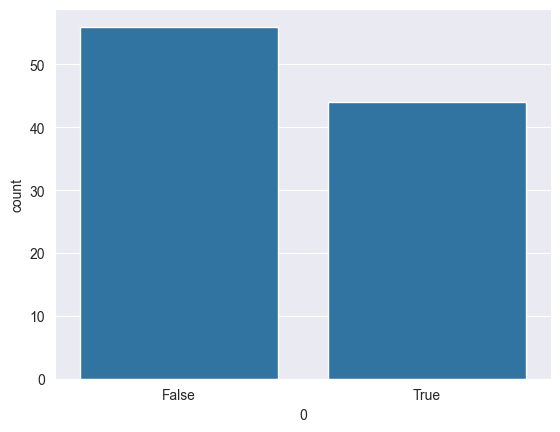

In [514]:
xx = arcene_train_labels[0].value_counts().reset_index()
print(xx)
sns.barplot(x=0, y='count', data=xx)

# Selection des features (caracteristiques)
Due que nous avons 10000 features avec des features aleatoires pour perturber le dataset et les algorithms, nous allons selectionner les features les plus importantes pour notre dataset.

Nous allons utiliser la methode des K-best features pour selectionner les features les plus importants.

Il existe d'autres methodes pour selectionner les features, comme la variance, la correlation, etc.

Commencer par la methode de la variance et pourquoi on ne l'a pas utilisee.

### Variance
La variance est une mesure de la dispersion des données. Elle est calculée comme la moyenne des carrés des écarts à la moyenne. Plus la variance est élevée, plus les données sont dispersées. Une variance nulle signifie que toutes les valeurs sont identiques.

On va calculer la variance de chaque feature, et on va selectionner les features avec les plus grandes variances.

Mais puisque nous avons des features aleatoires, la variance de ces features peut etre tres grande, et donc ca va choisir ces features aleatoires comme les plus importantes, ce qui va perturber les resultats de l'algorithme.

### K-best features

La méthode K-best est une méthode de sélection de caractéristiques univariée. Elle calcule la corrélation entre chaque caractéristique et la variable cible, puis sélectionne les caractéristiques qui ont la plus forte corrélation avec la variable cible.

Nous allons utiliser la méthode K-best pour sélectionner les 120 meilleures caractéristiques.

Avant faire ceci, le dataset contient des colonnes avec des valeurs constantes, donc on doit les supprimer.

Cette methode est utilisee pour trouver les colonnes non constantes :

In [515]:
def get_non_constant_columns(dataframe):
    return [col for col in dataframe.columns if len(dataframe[col].unique()) > 1]

Pour qu'on apres les laisser dans le dataset.

In [516]:
keep_columns = get_non_constant_columns(arcene_train)

arcene_train = arcene_train[keep_columns]

arcene_valid = arcene_valid[keep_columns]

arcene_test = arcene_test[keep_columns]

Ici on va utiliser la fonction SelectKBest pour selectionner les 120 meilleures caracteristiques. Dans les données on a 7000 caracteristiques, mais pas toutes sont importantes, le choix du nombre 120 n'est pas aleatoire, on a essaye plusieurs valeurs et on a trouve que 120 est la valeur qui donne les meilleurs resultats.

In [517]:
skb = SelectKBest(score_func=f_classif,  # Définir f_classif comme critère de sélection des caractéristiques
                  k=120)  # Sélectionner les 120 premières caractéristiques en fonction des critères

# Entraînement et transformation de l'ensemble des données selon la méthode SelectKBest
arcene_train_filtered = skb.fit_transform(arcene_train, arcene_train_labels)

print('Number of features before feature selection: {}'.format(arcene_train.shape[1]))
print('Number of features after feature selection: {}'.format(arcene_train_filtered.shape[1]))
print('Features selected: {}'.format(skb.get_support(indices=True)))

Number of features before feature selection: 9920
Number of features after feature selection: 120
Features selected: [   4    9   65   85  108  289  306  370  381  408  429  459  461  479
  530  686  770  789  846  860  901  970 1135 1171 1463 1707 1732 1734
 1773 1835 1869 1959 2117 2207 2289 2618 2676 2792 2840 3232 3336 3341
 3527 3573 3584 3660 3693 3787 3952 4036 4087 4149 4253 4481 4518 4587
 4743 4833 4914 4927 4959 4994 5136 5423 5704 5756 5853 5989 6070 6148
 6423 6443 6528 6625 6642 6707 6716 6869 6972 7032 7039 7101 7134 7156
 7365 7406 7476 7562 7585 7589 7635 7651 7668 7682 7790 7846 7854 7909
 7926 8080 8196 8275 8290 8297 8340 8390 8411 8431 8514 8712 8729 8733
 8757 8951 9202 9506 9538 9571 9580 9664]


D:\FST\MST - AIDS\S1\ML\PROJECTS\DEVOIR2\venv\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [518]:
arcene_train_filtered = pd.DataFrame(arcene_train_filtered)

arcene_train_filtered_concatinated = pd.concat([arcene_train_filtered, arcene_train_labels], axis=1, ignore_index=True)

print(arcene_train_filtered_concatinated)

    0    1    2    3    4    5    6    7    8    9    ...  111  112  113  114  \
0     0    0    0    0    0  466    3    0    0    6  ...    0    0    5  450   
1    60    0    9    0    0  395   92   85    0   83  ...    0   66   75  337   
2     0    0    0    0    0  483   19    2    0   21  ...    0    0   20  399   
3    14    0    0    0    0  439   56   42    0   55  ...    0   45   52  476   
4     0    1    0   38    0  342   44   19    0   49  ...   28  111   48  292   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0  177  164    0  200    0  183  152  203  194  ...    0    7  198   94   
96   71  163  159   43  136    0  190  171  136  195  ...   38   67  197   68   
97    0    0    0   15    0  467    0    4    0    2  ...   25    0    3  469   
98   69    3   19   14    0  420   12   26    0   10  ...   25   41    9  432   
99    0  112  100    0  174    0  111   94  177  117  ...    0    7  120  282   

    115  116  117  118  119

In [519]:
arcene_valid_filtered = skb.transform(arcene_valid)

arcene_valid_filtered = pd.DataFrame(arcene_valid_filtered)

arcene_valid_filtered_concatinated = pd.concat([arcene_valid_filtered, arcene_valid_labels], axis=1, ignore_index=True)

print(arcene_valid_filtered_concatinated)

    0    1    2    3    4    5    6    7    8    9    ...  111  112  113  114  \
0     2    0    0    1    0  410   21   40    0   14  ...    9    7   11  392   
1     0  222  202    0  145    0  195  160  151  213  ...    0   17  222  169   
2    53  147  133   39  143    0  137  106  142  145  ...   34   61  148   31   
3     0    0    4    0    0  437   15   24    0   11  ...    0   42    9  453   
4     2    0    0    0    0  470   21   24    0   16  ...    0    3   13  431   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95   92  261  254   86  297    0  274  254  298  282  ...   77  102  287  101   
96  109  134  121   69  148  145  193  170  150  203  ...   68   91  206  130   
97    0    0    0   15    0  263   17    0    0   20  ...    5   87   19  308   
98    0    4    9    0    9  388   83   75    8   80  ...    0    0   78  323   
99    0    0    1   46    0  277   55   25    0   55  ...   39  143   53  366   

    115  116  117  118  119

In [520]:
arcene_test_filtered = skb.transform(arcene_test)

arcene_test_filtered = pd.DataFrame(arcene_test_filtered)

print(arcene_test_filtered)

     0    1    2    3    4    5    6    7    8    9    ...  110  111  112  \
0      0   16   15   16    7  203   56   38    7   51  ...    9   15   92   
1     69  141  139   66  129    0  140  131  130  145  ...   71   63   86   
2      0  180  160    4  263  241  216  183  276  233  ...    0    5   10   
3      0    0    0    0    0  500   69   72    0   56  ...    0    0    7   
4     84  112  101   78  135  156  133  117  139  143  ...   59   74   86   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
695   55  144  133    0  174    0  136  115  175  143  ...    0    0   10   
696   30  127  121   46  137   57  119  101  138  128  ...   38   45   54   
697   18  214  190   44  218    0  206  166  222  220  ...   62   41   73   
698   38   30   34   28   57  477   27   19   69   33  ...    8   35   57   
699   18  215  193   64  243    0  182  140  247  197  ...   79   60   84   

     113  114  115  116  117  118  119  
0     47  332    0   45    5    0 

# Prétraitement des données

### Suppression des lignes dupliquées et des lignes avec des valeurs manquantes

In [521]:
missing_values = False
duplicates = False

# Suppression des lignes avec des valeurs manquantes
if arcene_train_filtered_concatinated.isna().values.any():
    missing_values = True
    arcene_train_filtered_concatinated.dropna(inpLace=True)
    
# Suppression des lignes dupliquées
if arcene_train_filtered_concatinated.duplicated().any():
    duplicates = True
    arcene_train_filtered_concatinated.drop_duplicates(inpLace=True)
    
# Resume
print("Missing values detected: ", missing_values)
print("Duplicate rows detected: ", duplicates)

print(arcene_train_filtered_concatinated)

Missing values detected:  False
Duplicate rows detected:  False
    0    1    2    3    4    5    6    7    8    9    ...  111  112  113  114  \
0     0    0    0    0    0  466    3    0    0    6  ...    0    0    5  450   
1    60    0    9    0    0  395   92   85    0   83  ...    0   66   75  337   
2     0    0    0    0    0  483   19    2    0   21  ...    0    0   20  399   
3    14    0    0    0    0  439   56   42    0   55  ...    0   45   52  476   
4     0    1    0   38    0  342   44   19    0   49  ...   28  111   48  292   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0  177  164    0  200    0  183  152  203  194  ...    0    7  198   94   
96   71  163  159   43  136    0  190  171  136  195  ...   38   67  197   68   
97    0    0    0   15    0  467    0    4    0    2  ...   25    0    3  469   
98   69    3   19   14    0  420   12   26    0   10  ...   25   41    9  432   
99    0  112  100    0  174    0  111   94  1

### Visualisation exemplaire d'un diagramme de dispersion

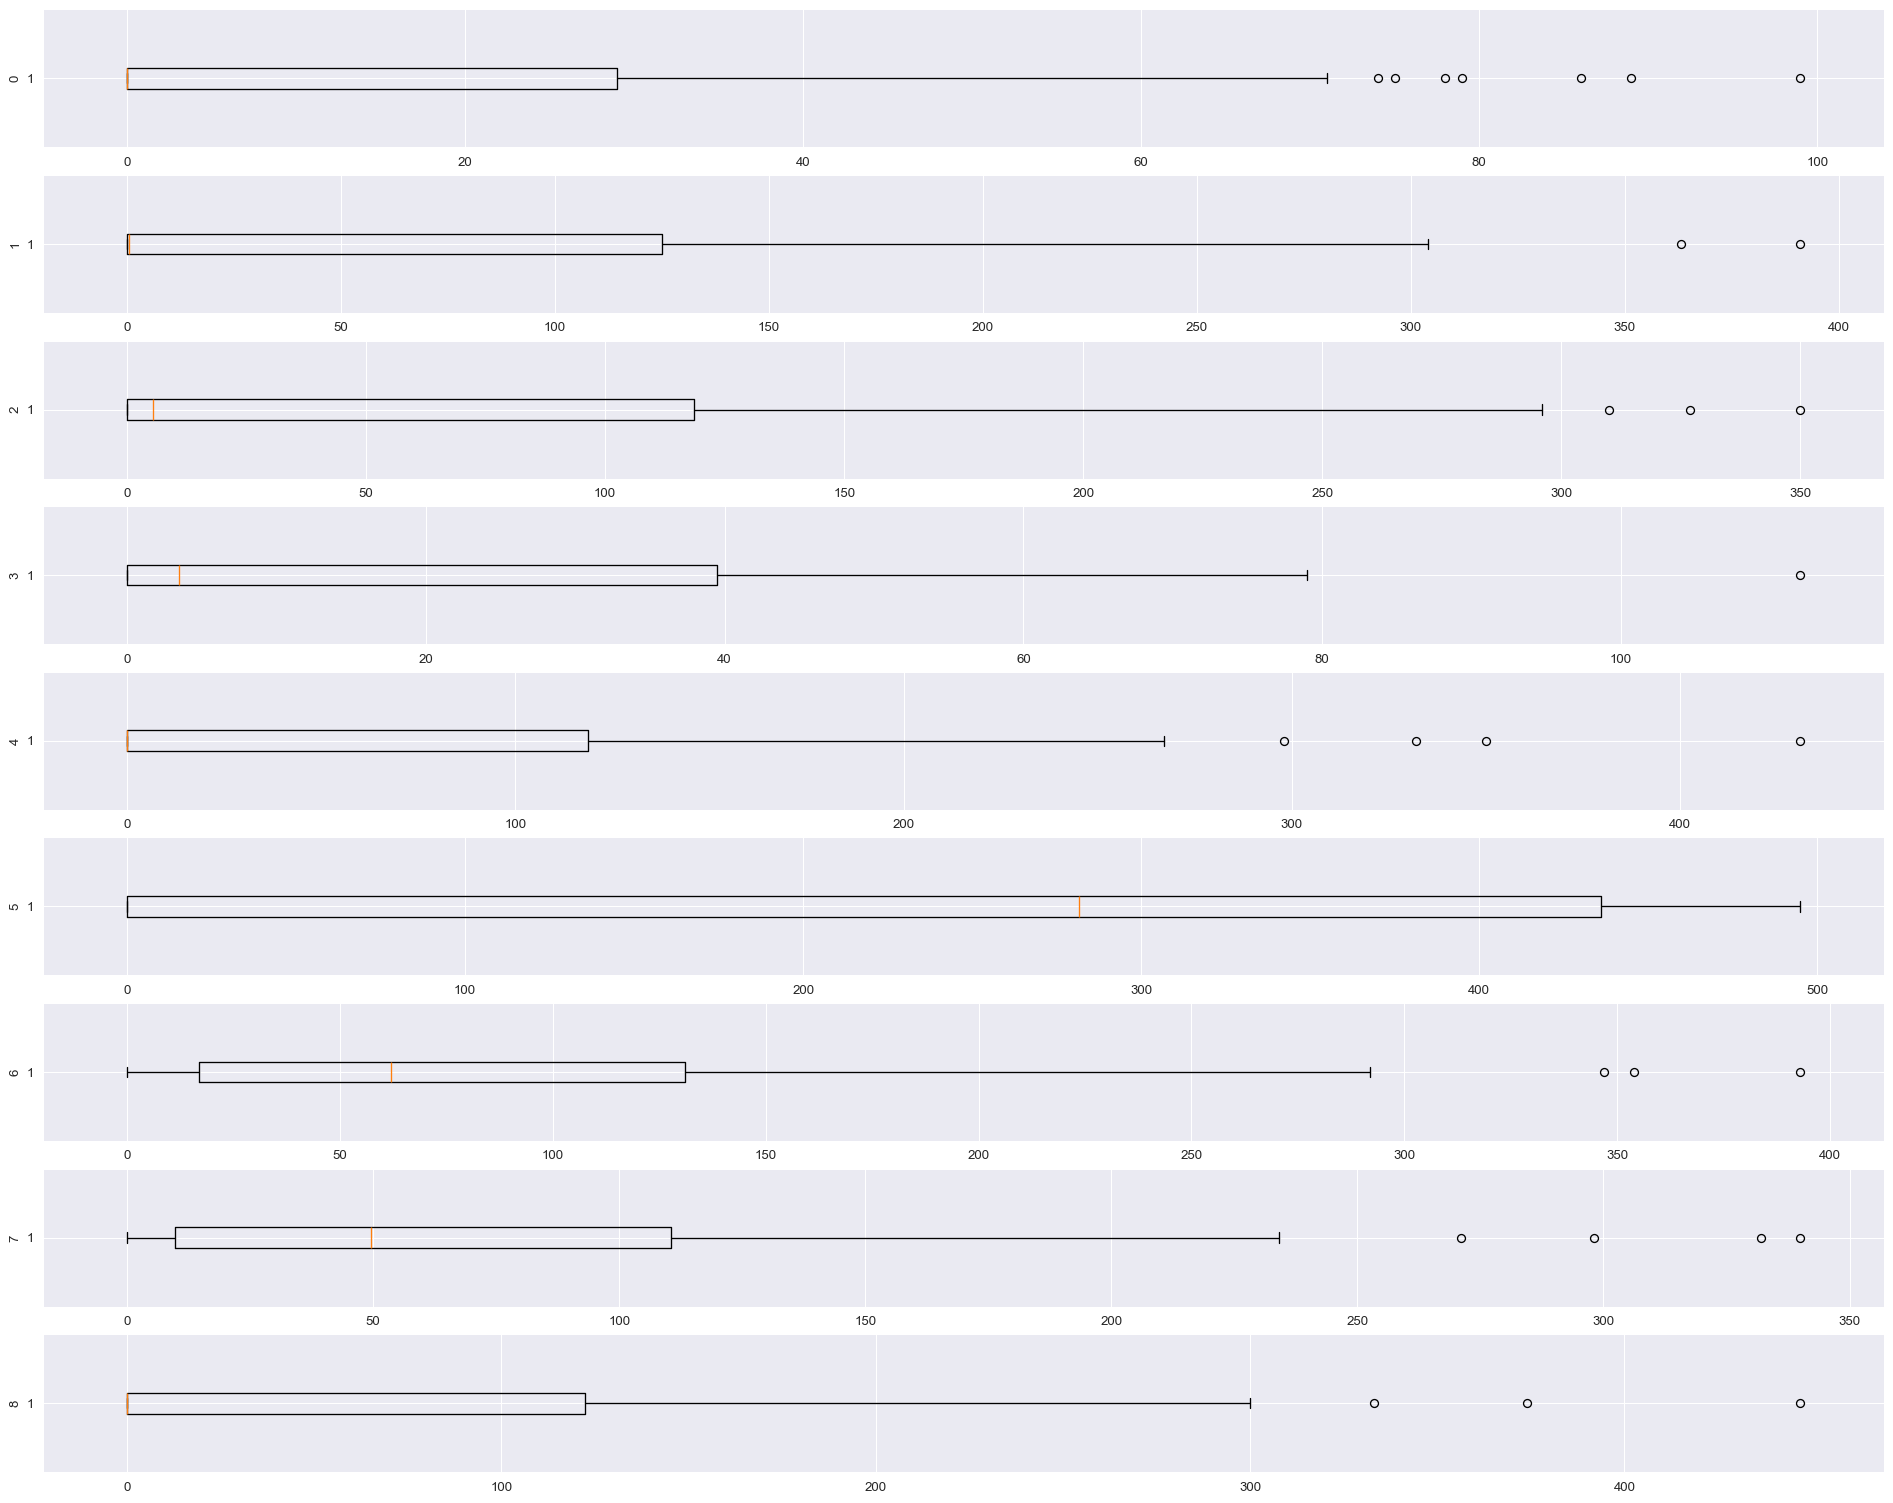

In [522]:
fig, axs = plt.subplots(9,1,dpi=95, figsize=(25,20))
i = 0
for col in range(9):
    axs[i].boxplot(arcene_train_filtered_concatinated[col], vert=False)
    axs[i].set_ylabel(col)
    i+=1
plt.show()

### Suppression des valeurs extrêmes (valeurs aberrantes)
##### Il existe de nombreuses techniques pour supprimer les valeurs aberrantes. Nous allons essayer l'approche basée sur le Z-score et le percentile.

##### Approche du score Z :

In [523]:
for col in arcene_train_filtered_concatinated.columns:
    arcene_train_filtered_concatinated[np.abs(stats.zscore(arcene_train_filtered_concatinated[col])) < 3]

# Resume
print("Number of outliers detected: ", 100 - arcene_train_filtered_concatinated.shape[0])

print(arcene_train_filtered_concatinated)

Number of outliers detected:  0
    0    1    2    3    4    5    6    7    8    9    ...  111  112  113  114  \
0     0    0    0    0    0  466    3    0    0    6  ...    0    0    5  450   
1    60    0    9    0    0  395   92   85    0   83  ...    0   66   75  337   
2     0    0    0    0    0  483   19    2    0   21  ...    0    0   20  399   
3    14    0    0    0    0  439   56   42    0   55  ...    0   45   52  476   
4     0    1    0   38    0  342   44   19    0   49  ...   28  111   48  292   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0  177  164    0  200    0  183  152  203  194  ...    0    7  198   94   
96   71  163  159   43  136    0  190  171  136  195  ...   38   67  197   68   
97    0    0    0   15    0  467    0    4    0    2  ...   25    0    3  469   
98   69    3   19   14    0  420   12   26    0   10  ...   25   41    9  432   
99    0  112  100    0  174    0  111   94  177  117  ...    0    7  120  282

##### Approche basée sur les percentiles :

Exemple de calcul des percentiles et de l'intervalle interquartile (IQR) pour une colonne

Suppression des valeurs aberrantes pour toutes les colonnes avec la méthode des percentiles:

In [524]:
for col in arcene_train_filtered_concatinated.columns[0:120]:
    if arcene_train_filtered_concatinated.shape[0] != 0:
        q1, q3 = np.percentile(arcene_train_filtered_concatinated[col], [25, 75], method='midpoint')
        iqr = q3 - q1
        upper_bound = q3 + (1.5 * iqr)
        lower_bound = q1 - (1.5 * iqr)

        # # Create arrays of Boolean values indicating the outlier rows
        # upper_array = np.where(arcene_train_filtered_concatinated[col] >= upper_bound)[0]
        # lower_array = np.where(arcene_train_filtered_concatinated[col] <= lower_bound)[0]
        # 
        # # Removing the outliers
        # for i, j in zip(upper_array, lower_array):
        #     if i in arcene_train_filtered_concatinated.index:
        #         arcene_train_filtered_concatinated.drop(index=upper_array, inplace=True)
        #     if j in arcene_train_filtered_concatinated.index:
        #         arcene_train_filtered_concatinated.drop(index=lower_array, inplace=True)

        arcene_train_filtered_concatinated = arcene_train_filtered_concatinated[((arcene_train_filtered_concatinated > lower_bound) & (arcene_train_filtered_concatinated < upper_bound)).any(axis=1)]

# Resume
print("Number of outliers detected: ", 100 - arcene_train_filtered_concatinated.shape[0])

print(arcene_train_filtered_concatinated)

Number of outliers detected:  0
    0    1    2    3    4    5    6    7    8    9    ...  111  112  113  114  \
0     0    0    0    0    0  466    3    0    0    6  ...    0    0    5  450   
1    60    0    9    0    0  395   92   85    0   83  ...    0   66   75  337   
2     0    0    0    0    0  483   19    2    0   21  ...    0    0   20  399   
3    14    0    0    0    0  439   56   42    0   55  ...    0   45   52  476   
4     0    1    0   38    0  342   44   19    0   49  ...   28  111   48  292   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0  177  164    0  200    0  183  152  203  194  ...    0    7  198   94   
96   71  163  159   43  136    0  190  171  136  195  ...   38   67  197   68   
97    0    0    0   15    0  467    0    4    0    2  ...   25    0    3  469   
98   69    3   19   14    0  420   12   26    0   10  ...   25   41    9  432   
99    0  112  100    0  174    0  111   94  177  117  ...    0    7  120  282

# Implementation de l'algorithme Naive Bayes

In [525]:
'''
encode_class(mydata) :
Entrée : mydata est une liste de listes où chaque liste intérieure représente une instance de données, et le dernier élément de chaque liste intérieure est l'étiquette de la classe.
Sortie : renvoie les données d'entrée avec les étiquettes de classe remplacées par les représentations numériques correspondantes.
'''
def encode_class(mydata):
    classes = []
    for i in range(len(mydata)):
        if mydata[i][-1] not in classes:
            classes.append(mydata[i][-1])
    for i in range(len(classes)):
        for j in range(len(mydata)):
            if mydata[j][-1] == classes[i]:
                mydata[j][-1] = i
    return mydata

'''
groupUnderClass(mydata) :
Entrée : mydata est une liste d'instances de données où le dernier élément de chaque liste intérieure est l'étiquette de la classe.
Résultat : Renvoie un dictionnaire dont les clés sont des étiquettes de classe uniques et les valeurs des listes d'instances de données appartenant à chaque classe.
'''
def groupUnderClass(mydata):
    data_dict = {}
    for i in range(len(mydata)):
        if mydata[i][-1] not in data_dict:
            data_dict[mydata[i][-1]] = []
        data_dict[mydata[i][-1]].append(mydata[i])
    return data_dict

'''
MeanAndStdDev(numbers) :
Entrée : nombres est une liste de valeurs numériques.
Sortie : renvoie la moyenne et l'écart-type de la liste d'entrée.
'''
def MeanAndStdDev(numbers):
    avg = np.mean(numbers)
    stddev = np.std(numbers)
    return avg, stddev

'''
MeanAndStdDevForClass(mydata) :
Entrée : mydata est une liste d'instances de données où le dernier élément de chaque liste intérieure est l'étiquette de la classe.
Résultat : Renvoie un dictionnaire dont les clés sont les étiquettes de classe et les valeurs sont des listes contenant la moyenne et l'écart type pour chaque attribut de cette classe.
'''
def MeanAndStdDevForClass(mydata):
    info = {}
    data_dict = groupUnderClass(mydata)
    for classValue, instances in data_dict.items():
        info[classValue] = [MeanAndStdDev(attribute) for attribute in zip(*instances)]
    return info

'''
calculateGaussianProbability(x, mean, stdev) :
Entrée : x est une valeur numérique, mean est la moyenne d'une distribution et stdev est l'écart-type.
Résultat : Calcule et renvoie la valeur de la fonction de densité de probabilité gaussienne pour les entrées données.
'''
def calculateGaussianProbability(x, mean, stdev):
    epsilon = 1e-10
    expo = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdev + epsilon, 2))))
    return (1 / (math.sqrt(2 * math.pi) * (stdev + epsilon))) * expo

'''
calculateClassProbabilities(info, test) :
Entrée : info est un dictionnaire contenant des informations sur la moyenne et l'écart-type par classe, et test est une liste représentant une instance de test.
Résultat : Renvoie un dictionnaire dont les clés sont les étiquettes de classe et les valeurs sont les probabilités calculées pour l'instance de test donnée.
'''
def calculateClassProbabilities(info, test):
    probabilities = {}
    for classValue, classSummaries in info.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, std_dev = classSummaries[i]
            x = test[i]
            probabilities[classValue] *= calculateGaussianProbability(x, mean, std_dev)
    print(probabilities)
    return probabilities

'''
predict(info, test) :
Entrée : info est un dictionnaire contenant des informations sur la moyenne et l'écart-type de la classe, et test est une liste représentant une instance de test.
Résultat : Renvoie l'étiquette de classe prédite pour l'instance de test donnée.
'''
def predict(info, test):
    probabilities = calculateClassProbabilities(info, test)
    bestLabel = max(probabilities, key=probabilities.get)
    return bestLabel

'''
getPredictions(info, test) :
Entrée : info est un dictionnaire contenant des informations sur la moyenne par classe et l'écart-type, et test est une liste représentant une instance de test.
Résultat : Retourne une liste d'étiquettes de classe prédites pour chaque instance de test.
'''
def getPredictions(info, test):
    predictions = [predict(info, instance) for instance in test]
    print(predictions)
    return predictions

'''
accuracy_rate(test, predictions) :
Entrée : test est une liste d'instances de test, et predictions est une liste d'étiquettes de classe prédites.
Résultat : Renvoie le taux de précision (pourcentage) en comparant les étiquettes prédites avec les étiquettes réelles dans les données de test.
'''
def accuracy_rate(test, predictions):
    correct = sum(1 for i in range(len(test)) if test[i][-1] == predictions[i])
    return (correct / float(len(test))) * 100.0

# Apprentissage et test de l'algorithme

In [526]:
# Apprentissage
info = MeanAndStdDevForClass(arcene_train_filtered_concatinated.values)

# Test
predictions = getPredictions(info, arcene_valid_filtered_concatinated.values)

{True: 0.0, False: 1.6039246740998063e-283}
{True: 0.0, False: 3.0099820334070873e-287}
{True: 0.0, False: 1.3980039967008995e-268}
{True: 2.20728110755404e-236, False: 0.0}
{True: 2.4643969031066857e-244, False: 0.0}
{True: 7.027374345988493e-239, False: 0.0}
{True: 0.0, False: 1.3772580437612362e-291}
{True: 3.2334053491781066e-245, False: 0.0}
{True: 0.0, False: 0.0}
{True: 0.0, False: 1.7204182655654697e-268}
{True: 0.0, False: 0.0}
{True: 0.0, False: 8.110789893030343e-291}
{True: 0.0, False: 6.350879578291261e-282}
{True: 3.0296413849871043e-232, False: 0.0}
{True: 0.0, False: 9.918498967920865e-289}
{True: 0.0, False: 4.4355876573188733e-262}
{True: 0.0, False: 0.0}
{True: 7.049755942990839e-239, False: 0.0}
{True: 4.7452131434053393e-240, False: 0.0}
{True: 0.0, False: 0.0}
{True: 1.8468208819377323e-237, False: 0.0}
{True: 0.0, False: 1.5283643563752338e-272}
{True: 9.742450202558404e-241, False: 0.0}
{True: 0.0, False: 7.332769037250795e-271}
{True: 5.740437351011618e-239, Fa

### Matrice de confusion
La matrice de confusion est une matrice qui permet de visualiser les performances d'un algorithme de classification. 

In [527]:
cm = metrics.confusion_matrix(arcene_valid_labels, predictions)

cm

array([[50,  6],
       [ 0, 44]], dtype=int64)

### Visualisation de la matrice de confusion

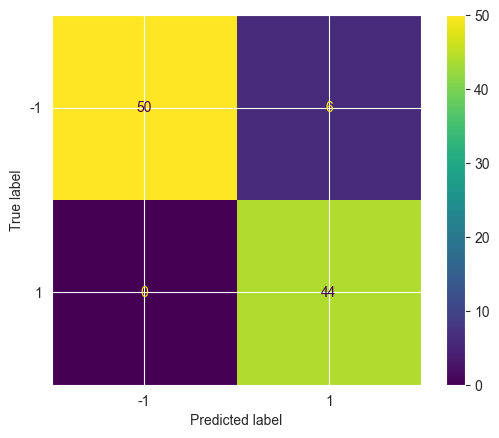

In [528]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot()

plt.show()

### Calcul des métriques
Les métriques qui seront calculées sont :
- Balanced Error Rate
- Accuracy
- Precision
- Recall
- F1 Score
- AUC Score
- ROC Curve

Ces metriques on ete conseillees par les juges du challenge Arcene pour evaluer les performances des algorithmes de classification. (https://web.archive.org/web/20130503080434/http://www.nipsfsc.ecs.soton.ac.uk/evaluation)
Pour plus d'informations sur ces métriques, veuillez consulter ce lien : https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

In [529]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

BER = 1 - (1/2 * ((TP / (TP + FN)) + (TN / (TN + FP))))

precision = metrics.precision_score(arcene_valid_labels, predictions, average='macro')

recall = metrics.recall_score(arcene_valid_labels, predictions, average='macro')

f1_score = metrics.f1_score(arcene_valid_labels, predictions, average='macro')

accuracy = metrics.accuracy_score(arcene_valid_labels, predictions)

auc_score = metrics.roc_auc_score(arcene_valid_labels, predictions)

print('Balanced Error Rate: ', BER)
print('Accuracy:            ', accuracy)
print('Precision:           ', precision)
print('Recall:              ', recall)
print('F1 Score:            ', f1_score)
print('AUC Score:           ', auc_score)

Balanced Error Rate:  0.06000000000000005
Accuracy:             0.94
Precision:            0.94
Recall:               0.9464285714285714
F1 Score:             0.939783219590526
AUC Score:            0.9464285714285715


##### Courbe ROC:

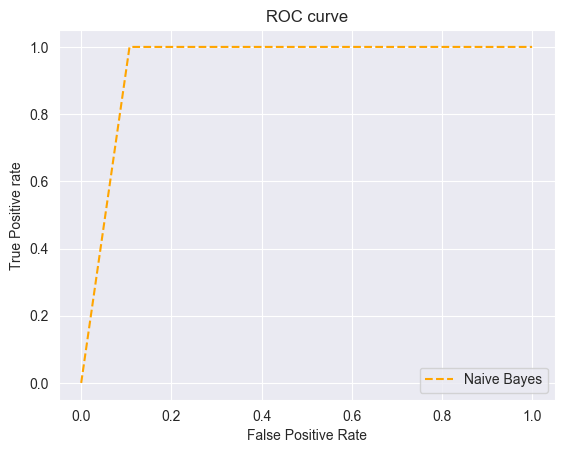

In [530]:
fpr, tpr, thresh = metrics.roc_curve(arcene_valid_labels, predictions, pos_label=1)

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Naive Bayes')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

Ajouter une colonne inutile au donnees de test just pour pouvoir les tester avec l'algorithme.

In [531]:
arcene_test_filtered_ = arcene_test_filtered.copy()

arcene_test_filtered_[120] = 0

Predire les classes des donnees de test:

In [532]:
test_pred = getPredictions(info, arcene_test_filtered_.values)

{True: 0.0, False: 9.185158029851641e-271}
{True: 0.0, False: 8.308697627013564e-280}
{True: 0.0, False: 2.5195626350302223e-291}
{True: 0.0, False: 7.618802745283562e-285}
{True: 0.0, False: 1.2721960609443858e-281}
{True: 0.0, False: 3.597388048651499e-263}
{True: 0.0, False: 3.6577140638198676e-278}
{True: 0.0, False: 2.814054701699312e-292}
{True: 0.0, False: 2.7266431500755856e-270}
{True: 0.0, False: 1.9885568017264632e-289}
{True: 0.0, False: 0.0}
{True: 0.0, False: 1.1478157423057856e-262}
{True: 0.0, False: 5.887051599068096e-290}
{True: 0.0, False: 2.561782492331327e-292}
{True: 0.0, False: 7.272165971938601e-281}
{True: 0.0, False: 6.856124956692705e-285}
{True: 0.0, False: 2.4246295539489234e-277}
{True: 0.0, False: 2.318915233413391e-280}
{True: 0.0, False: 3.081897186556936e-267}
{True: 0.0, False: 2.4596581830581373e-276}
{True: 0.0, False: 7.293263401441386e-289}
{True: 0.0, False: 1.0443368870636472e-286}
{True: 0.0, False: 6.859245750975895e-278}
{True: 0.0, False: 6.

### Visualisation des classes predites

       0  count
0  False    669
1   True     31


<Axes: xlabel='0', ylabel='count'>

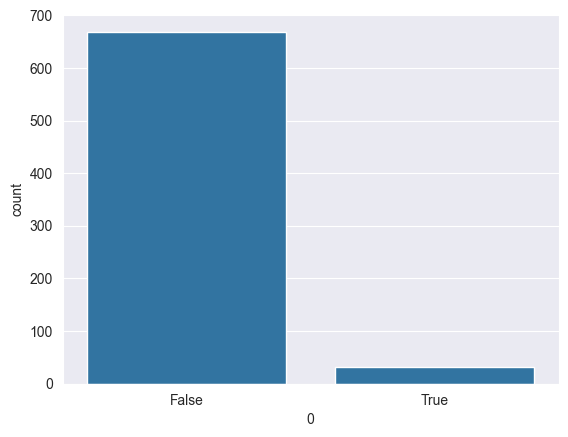

In [533]:
test_pred = pd.DataFrame(test_pred)

yy = test_pred.value_counts().reset_index()
print(yy)
sns.barplot(x=0, y='count', data=yy)

# Comparaison avec l'algorithme Naive Bayes de sklearn
Maintenant on va comparer les resultats obtenus avec notre algorithme avec ceux obtenus avec l'algorithme Naive Bayes de sklearn.

In [534]:
gnb = GaussianNB()

arcene_train_labels_serie = arcene_train_labels.squeeze()

gnb.fit(arcene_train_filtered, arcene_train_labels_serie)

y_pred = gnb.predict(arcene_valid_filtered)

pred_len = len(y_pred)

y_pred = y_pred.reshape(pred_len, 1)

print("Nombre de points mal étiquetés sur un total de %d points : %d" % (arcene_valid.shape[0], (arcene_valid_labels != y_pred).sum().iloc[0]))

Nombre de points mal étiquetés sur un total de 100 points : 30


### Matrice de confusion

In [535]:
cm_with_sklearn = metrics.confusion_matrix(arcene_valid_labels, y_pred)

cm_with_sklearn

array([[37, 19],
       [11, 33]], dtype=int64)

### Visualisation de la matrice de confusion

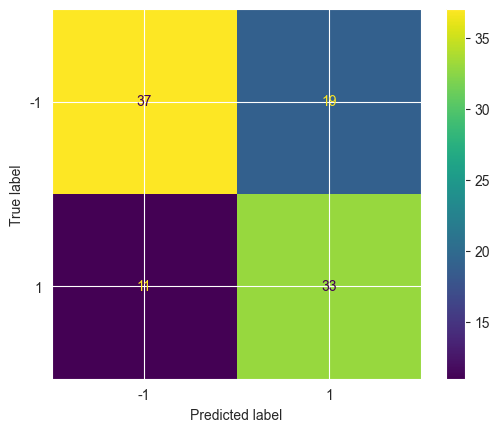

In [536]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_with_sklearn, display_labels=[-1, 1])
disp.plot()

plt.show()

### Calcul des métriques
Les métriques qui seront calculées sont :
- Balanced Error Rate
- Accuracy
- Precision
- Recall
- F1 Score
- AUC Score
- ROC Curve

In [537]:
TP_with_sklearn = cm_with_sklearn[0][0]
FP_with_sklearn = cm_with_sklearn[0][1]
FN_with_sklearn = cm_with_sklearn[1][0]
TN_with_sklearn = cm_with_sklearn[1][1]

BER_with_sklearn = 1 - (1/2 * ((TP_with_sklearn / (TP_with_sklearn + FN_with_sklearn)) + (TN_with_sklearn / (TN_with_sklearn + FP_with_sklearn))))

precision_with_sklearn = metrics.precision_score(arcene_valid_labels, y_pred, average='macro')

recall_with_sklearn = metrics.recall_score(arcene_valid_labels, y_pred, average='macro')

f1_score_with_sklearn = metrics.f1_score(arcene_valid_labels, y_pred, average='macro')

accuracy_with_sklearn = metrics.accuracy_score(arcene_valid_labels, y_pred)

auc_score_with_sklearn = metrics.roc_auc_score(arcene_valid_labels, y_pred)

print('Balanced Error Rate: ', BER_with_sklearn)
print('Accuracy:            ', accuracy_with_sklearn)
print('Precision:           ', precision_with_sklearn)
print('Recall:              ', recall_with_sklearn)
print('F1 Score:            ', f1_score_with_sklearn)
print('AUC Score:           ', auc_score_with_sklearn)

Balanced Error Rate:  0.29727564102564097
Accuracy:             0.7
Precision:            0.702724358974359
Recall:               0.7053571428571428
F1 Score:             0.6995192307692308
AUC Score:            0.7053571428571428


##### Courbe ROC:

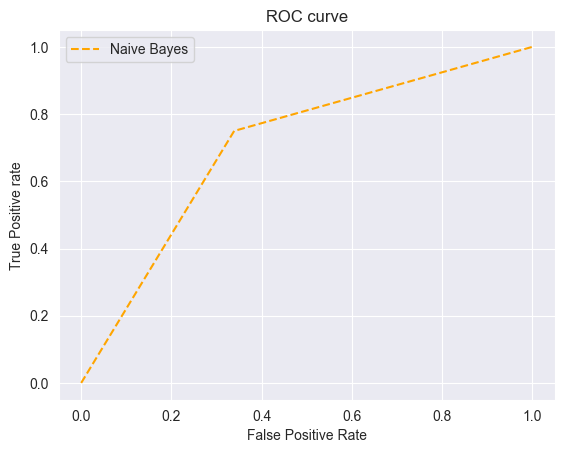

In [538]:
fpr_with_sklearn, tpr_with_sklearn, thresh_with_sklearn = metrics.roc_curve(arcene_valid_labels, y_pred, pos_label=1)

# plot roc curves
plt.plot(fpr_with_sklearn, tpr_with_sklearn, linestyle='--',color='orange', label='Naive Bayes')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

In [539]:
test_pred_with_sklearn = gnb.predict(arcene_test_filtered)

pred_len = len(test_pred_with_sklearn)

test_pred_with_sklearn = test_pred_with_sklearn.reshape(pred_len, 1)

       0  count
0   True    432
1  False    268


<Axes: xlabel='0', ylabel='count'>

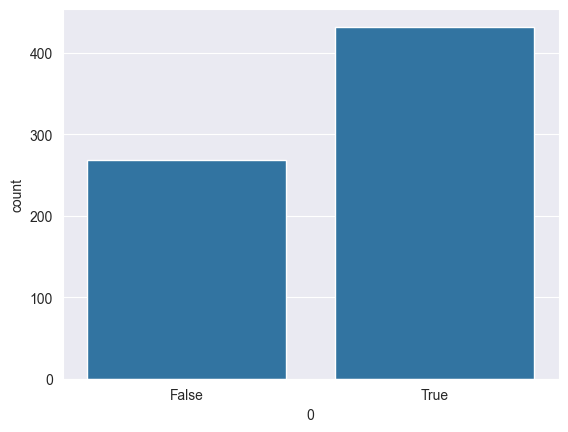

In [540]:
test_pred_with_sklearn = pd.DataFrame(test_pred_with_sklearn)

yy_with_sklearn = test_pred_with_sklearn.value_counts().reset_index()
print(yy_with_sklearn)
sns.barplot(x=0, y='count', data=yy_with_sklearn)

# Implementation de l'algorithme Extreme Gradient Boosting (XGBoost):

In [541]:
class Node:

    '''
    Un objet nœud qui est appelé de manière récurrente en son sein pour construire un arbre de régression. Basé sur XGBoost de Tianqi Chen 
    le gain interne utilisé pour trouver la valeur de division optimale utilise à la fois le gradient et la valeur hessienne. De même, une esquisse de quantlie pondérée 
    et les valeurs optimales des feuilles suivent la description de Chen dans "XGBoost : A Scalable Tree Boosting System", la seule chose qui n'est pas implémentée dans cette version est la sparsité. 
    Dans cette version, la seule chose qui n'a pas été implémentée est l'ajustement tenant compte de l'éparpillement ou la capacité à gérer les valeurs NA avec une direction par défaut.
    
    Entrées
    ------------------------------------------------------------------------------------------------------------------
    x : cadre de données pandas des données d'apprentissage
    gradient : gradient négatif de la fonction de perte
    hessian : dérivée de second ordre de la fonction de perte
    idxs : utilisé pour garder une trace des échantillons dans la structure de l'arbre
    subsample_cols : implémentation d'un sous-échantillon de colonnes par couches qui randomise la structure des arbres.
    (paramètre de complexité)
    min_leaf : nombre minimum d'échantillons pour qu'un nœud soit considéré comme tel (paramètre de complexité)
    min_child_weight : la somme des heassian à l'intérieur d'un noeud est une mesure de la pureté (paramètre de complexité)
    depth : limite le nombre de couches dans l'arbre
    lambda : terme de régularisation L2 sur les poids. L'augmentation de cette valeur rendra le modèle plus conservateur.
    gamma : Ce paramètre empêche également l'ajustement excessif et est présent dans le calcul du gain (score de structure). 
    Comme il est soustrait du gain, il fixe essentiellement un gain minimum pour effectuer une scission dans un nœud.
    eps : Ce paramètre est utilisé dans la méthode du quantile weighted skecth ou de l'arbre "approximatif". 
    (1 / sketch_eps) nombre de cellules
    Résultats
    --------------------------------------------------------------------------------------------------------------------
    Un objet arbre unique qui sera utilisé pour le renforcement du gradient.
    '''

    def __init__(self, x, gradient, hessian, idxs, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):

        self.x, self.gradient, self.hessian = x, gradient, hessian
        self.idxs = idxs 
        self.depth = depth
        self.min_leaf = min_leaf
        self.lambda_ = lambda_
        self.gamma  = gamma
        self.min_child_weight = min_child_weight
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.column_subsample = np.random.permutation(self.col_count)[:round(self.subsample_cols*self.col_count)]

        self.val = self.compute_gamma(self.gradient[self.idxs], self.hessian[self.idxs])

        self.score = float('-inf')
        self.find_varsplit()


    def compute_gamma(self, gradient, hessian):
        '''
        Calcule la valeur optimale de la feuille équation (5) dans "XGBoost : Un système de booster d'arbre évolutif"
        '''
        return(-np.sum(gradient)/(np.sum(hessian) + self.lambda_))

    def find_varsplit(self):
        '''
        Examine chaque colonne et calcule le meilleur point de séparation.
        Le nœud est alors divisé en ce point et deux nouveaux nœuds sont créés.
        La profondeur est le seul paramètre à modifier, car nous avons ajouté une nouvelle couche à la structure de l'arbre.
        Si aucune scission n'est meilleure que le score initialisé au début, aucune scission n'est effectuée.
        '''
        for c in self.column_subsample: self.find_greedy_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[lhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)
        self.rhs = Node(x = self.x, gradient = self.gradient, hessian = self.hessian, idxs = self.idxs[rhs], min_leaf = self.min_leaf, depth = self.depth-1, lambda_ = self.lambda_ , gamma = self.gamma, min_child_weight = self.min_child_weight, eps = self.eps, subsample_cols = self.subsample_cols)

    def find_greedy_split(self, var_idx):
        '''
        Pour une caractéristique donnée, calcule avec avidité le gain à chaque division.
        Met à jour globalement le meilleur score et le point de séparation si un meilleur point de séparation est trouvé.
        '''
        x = self.x.values[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]

            lhs_indices = np.nonzero(x <= x[r])[0]
            rhs_indices = np.nonzero(x > x[r])[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue

            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]

    def weighted_qauntile_sketch(self, var_idx):
        '''
        XGBOOST Mini-Version
        Yiyang "Joe" Zeng
        Est une approximation de l'approche eact greedy plus rapide pour les grands ensembles de données où il n'est pas possible de calculer le gain à chaque point de séparation.
        de calculer le gain à chaque point de partage. Utilise les équations (8) et (9) de "XGBoost : A Scalable Tree Boosting System" (Un système évolutif de renforcement des arbres)
        '''
        x = self.x.values[self.idxs, var_idx]
        hessian_ = self.hessian[self.idxs]
        df = pd.DataFrame({'feature':x,'hess':hessian_})

        df.sort_values(by=['feature'], ascending = True, inplace = True)
        hess_sum = df['hess'].sum() 
        df['rank'] = df.apply(lambda x : (1/hess_sum)*sum(df[df['feature'] < x['feature']]['hess']), axis=1)

        for row in range(df.shape[0]-1):
            # look at the current rank and the next ran
            rk_sk_j, rk_sk_j_1 = df['rank'].iloc[row:row+2]
            diff = abs(rk_sk_j - rk_sk_j_1)
            if(diff >= self.eps):
                continue

            split_value = (df['rank'].iloc[row+1] + df['rank'].iloc[row])/2
            lhs = x <= split_value
            rhs = x > split_value

            lhs_indices = np.nonzero(x <= split_value)[0]
            rhs_indices = np.nonzero(x > split_value)[0]
            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf 
               or self.hessian[lhs_indices].sum() < self.min_child_weight
               or self.hessian[rhs_indices].sum() < self.min_child_weight): continue

            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = split_value

    def gain(self, lhs, rhs):
        '''
        Calcule le gain à un point de partage particulier sur la base de l'équation (7) de
        "XGBoost : Un système évolutif de renforcement des arbres
        '''
        gradient = self.gradient[self.idxs]
        hessian  = self.hessian[self.idxs]

        lhs_gradient = gradient[lhs].sum()
        lhs_hessian  = hessian[lhs].sum()

        rhs_gradient = gradient[rhs].sum()
        rhs_hessian  = hessian[rhs].sum()

        gain = 0.5 *( (lhs_gradient**2/(lhs_hessian + self.lambda_)) + (rhs_gradient**2/(rhs_hessian + self.lambda_)) - ((lhs_gradient + rhs_gradient)**2/(lhs_hessian + rhs_hessian + self.lambda_))) - self.gamma
        return(gain)

    @property
    def split_col(self):
        '''
        splits a column 
        '''
        return self.x.values[self.idxs , self.var_idx]

    @property
    def is_leaf(self):
        '''
        checks if node is a leaf
        '''
        return self.score == float('-inf') or self.depth <= 0                 

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf:
            return(self.val)

        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)


class XGBoostTree:
    '''
    Classe enveloppante qui fournit une interface scikit learn à l'arbre de régression récursif ci-dessus.
    
    Entrées
    ------------------------------------------------------------------------------------------------------------------
    x : datframe pandas des données d'apprentissage
    gradient : gradient négatif de la fonction de perte
    hessian : dérivée de second ordre de la fonction de perte
    idxs : utilisé pour garder une trace des échantillons dans la structure de l'arbre
    subsample_cols : implémentation d'un sous-échantillon de colonnes par couches qui randomise la structure des arbres.
    (paramètre de complexité)
    min_leaf : nombre minimum d'échantillons pour qu'un nœud soit considéré comme tel (paramètre de complexité)
    min_child_weight : la somme des heassian à l'intérieur d'un noeud est une mesure de la pureté (paramètre de complexité)
    depth : limite le nombre de couches dans l'arbre
    lambda : terme de régularisation L2 sur les poids. L'augmentation de cette valeur rendra le modèle plus conservateur.
    gamma : Ce paramètre empêche également l'ajustement excessif et est présent dans le calcul du gain (score de structure). 
    Comme il est soustrait du gain, il fixe essentiellement un gain minimum pour effectuer une scission dans un nœud.
    eps : Ce paramètre est utilisé dans la méthode du quantile weighted skecth ou de l'arbre "approximatif". 
    (1 / sketch_eps) nombre de cellules

    Résultats
    --------------------------------------------------------------------------------------------------------------------
    Un seul objet arbre qui sera utilisé pour le gradient.
    '''
    def fit(self, x, gradient, hessian, subsample_cols = 0.8 , min_leaf = 5, min_child_weight = 1 ,depth = 10, lambda_ = 1, gamma = 1, eps = 0.1):
        self.dtree = Node(x, gradient, hessian, np.array(np.arange(len(x))), subsample_cols, min_leaf, min_child_weight, depth, lambda_, gamma, eps)
        return self

    def predict(self, X):
        return self.dtree.predict(X.values)


class XGBoostClassifier:
    '''
    Application complète de l'algorithme XGBoost tel que décrit dans "XGBoost : A Scalable Tree Boosting System" pour la classification binaire.
    
    Entrées
    ------------------------------------------------------------------------------------------------------------------
    x : cadre de données pandas des données d'apprentissage
    gradient : gradient négatif de la fonction de perte
    hessian : dérivée de second ordre de la fonction de perte
    idxs : utilisé pour garder une trace des échantillons dans la structure de l'arbre
    subsample_cols : implémentation d'un sous-échantillon de colonnes par couches qui randomise la structure des arbres.
    (paramètre de complexité)
    min_leaf : nombre minimum d'échantillons pour qu'un nœud soit considéré comme tel (paramètre de complexité)
    min_child_weight : la somme des heassian à l'intérieur d'un noeud est une mesure de la pureté (paramètre de complexité)
    depth : limite le nombre de couches dans l'arbre
    lambda : terme de régularisation L2 sur les poids. L'augmentation de cette valeur rendra le modèle plus conservateur.
    gamma : Ce paramètre empêche également l'ajustement excessif et est présent dans le calcul du gain (score de structure). 
    Comme il est soustrait du gain, il fixe essentiellement un gain minimum pour effectuer une scission dans un nœud.
    eps : Ce paramètre est utilisé dans la méthode du quantile weighted skecth ou de l'arbre "approximatif". 
    (1 / sketch_eps) nombre de cellules
    Résultats
    --------------------------------------------------------------------------------------------------------------------
    Un seul objet arbre qui sera utilisé pour le gradient.
    '''
    def __init__(self):
        self.estimators = []

    def get_params(self, deep=False):
        return {
            'subsample_cols': self.subsample_cols,
            'min_child_weight': self.min_child_weight,
            'depth': self.depth,
            'min_leaf': self.min_leaf,
            'learning_rate': self.learning_rate,
            'boosting_rounds': self.boosting_rounds,
            'lambda_': self.lambda_,
            'gamma': self.gamma,
            'eps': self.eps
        }


    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # first order gradient logLoss
    def grad(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds - labels)

    # second order gradient logLoss
    def hess(self, preds, labels):
        preds = self.sigmoid(preds)
        return(preds * (1 - preds))

    @staticmethod
    def log_odds(column):
        binary_yes = np.count_nonzero(column == 1)
        binary_no  = np.count_nonzero(column == 0)
        return(np.log(binary_yes/binary_no))


    def fit(self, X, y, subsample_cols = 0.8 , min_child_weight = 1, depth = 5, min_leaf = 5, learning_rate = 0.4, boosting_rounds = 5, lambda_ = 1.5, gamma = 1, eps = 0.1):
        self.X, self.y = X, y
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight 
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds 
        self.lambda_ = lambda_
        self.gamma  = gamma

        self.base_pred = np.full((X.shape[0], 1), 1).flatten().astype('float64')

        for booster in range(self.boosting_rounds):
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred, self.y)
            boosting_tree = XGBoostTree().fit(self.X, Grad, Hess, depth = self.depth, min_leaf = self.min_leaf, lambda_ = self.lambda_, gamma = self.gamma, eps = self.eps, min_child_weight = self.min_child_weight, subsample_cols = self.subsample_cols)
            self.base_pred += self.learning_rate * boosting_tree.predict(self.X)
            self.estimators.append(boosting_tree)

    def predict_proba(self, X):
        pred = np.zeros(X.shape[0])

        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 

        return(self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred))

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 

        predicted_probas = self.sigmoid(np.full((X.shape[0], 1), 1).flatten().astype('float64') + pred)
        preds = np.where(predicted_probas > np.mean(predicted_probas), 1, 0)
        return(preds)


class XGBoostRegressor:
    '''
    Application complète de l'algorithme XGBoost tel que décrit dans "XGBoost : A Scalable Tree Boosting System" pour la régression.
    
    Entrées
    ------------------------------------------------------------------------------------------------------------------
    x : cadre de données pandas des données d'apprentissage
    gradient : gradient négatif de la fonction de perte
    hessian : dérivée de second ordre de la fonction de perte
    idxs : utilisé pour garder une trace des échantillons dans la structure de l'arbre
    subsample_cols : implémentation d'un sous-échantillon de colonnes par couches qui randomise la structure des arbres.
    (paramètre de complexité)
    min_leaf : nombre minimum d'échantillons pour qu'un nœud soit considéré comme tel (paramètre de complexité)
    min_child_weight : la somme des heassian à l'intérieur d'un noeud est une mesure de la pureté (paramètre de complexité)
    depth : limite le nombre de couches dans l'arbre
    lambda : terme de régularisation L2 sur les poids. L'augmentation de cette valeur rendra le modèle plus conservateur.
    gamma : Ce paramètre empêche également l'ajustement excessif et est présent dans le calcul du gain (score de structure). 
    Comme il est soustrait du gain, il fixe essentiellement un gain minimum pour effectuer une scission dans un nœud.
    eps : Ce paramètre est utilisé dans la méthode du quantile weighted skecth ou de l'arbre "approximatif". 
    (1 / sketch_eps) nombre de cellules
    Résultats
    --------------------------------------------------------------------------------------------------------------------
    Un seul objet arbre qui sera utilisé pour le gradient.
    '''
    def __init__(self):
        self.estimators = []

    def get_params(self):
        return {
            'subsample_cols': self.subsample_cols,
            'min_child_weight': self.min_child_weight,
            'depth': self.depth,
            'min_leaf': self.min_leaf,
            'learning_rate': self.learning_rate,
            'boosting_rounds': self.boosting_rounds,
            'lambda_': self.lambda_,
            'gamma': self.gamma,
            'eps': self.eps
        }
    # first order gradient mean squared error
    @staticmethod
    def grad(preds, labels):
        return(2*(preds-labels))

    # second order gradient logLoss
    @staticmethod
    def hess(preds, labels):
        '''
        la hessienne de l'erreur quadratique moyenne est une valeur constante de deux
        renvoie un tableau de deux
        '''
        return(np.full((preds.shape[0], 1), 2).flatten().astype('float64'))


    def fit(self, X, y, subsample_cols = 0.8 , min_child_weight = 1, depth = 5, min_leaf = 5, learning_rate = 0.4, boosting_rounds = 5, lambda_ = 1.5, gamma = 1, eps = 0.1):
        self.X, self.y = X, y.values
        self.depth = depth
        self.subsample_cols = subsample_cols
        self.eps = eps
        self.min_child_weight = min_child_weight 
        self.min_leaf = min_leaf
        self.learning_rate = learning_rate
        self.boosting_rounds = boosting_rounds 
        self.lambda_ = lambda_
        self.gamma  = gamma

        self.base_pred = np.full((X.shape[0], 1), np.mean(y)).flatten().astype('float64')

        for booster in range(self.boosting_rounds):
            Grad = self.grad(self.base_pred, self.y)
            Hess = self.hess(self.base_pred, self.y)
            boosting_tree = XGBoostTree().fit(self.X, Grad, Hess, depth = self.depth, min_leaf = self.min_leaf, lambda_ = self.lambda_, gamma = self.gamma, eps = self.eps, min_child_weight = self.min_child_weight, subsample_cols = self.subsample_cols)
            self.base_pred += self.learning_rate * boosting_tree.predict(self.X)
            self.estimators.append(boosting_tree)

    def predict(self, X):
        pred = np.zeros(X.shape[0])

        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X) 

        return np.full((X.shape[0], 1), np.mean(y)).flatten().astype('float64') + pred

# Apprentissage et test de l'algorithme

In [542]:
xgb = XGBoostClassifier()

arcene_train_labels_reshaped = arcene_train_labels.values.reshape(len(arcene_train_labels), 1)
arcene_valid_labels_reshaped = arcene_valid_labels.values.reshape(len(arcene_train_labels), 1)

xgb.fit(arcene_train_filtered, arcene_train_labels_reshaped, depth = 5, min_leaf = 5, learning_rate = 0.1, boosting_rounds = 5)

predictions = xgb.predict(arcene_valid_filtered)

pred_len = len(predictions)

predictions = predictions.reshape(pred_len, 1)

print("Number of mislabeled points out of a total %d points : %d" % (arcene_valid.shape[0], (arcene_valid_labels_reshaped != predictions).sum()))

Number of mislabeled points out of a total 100 points : 35


### Matrice de confusion
La matrice de confusion est une matrice qui permet de visualiser les performances d'un algorithme de classification. 

In [543]:
cm = metrics.confusion_matrix(arcene_valid_labels, predictions)

cm

array([[52,  4],
       [31, 13]], dtype=int64)

### Visualisation de la matrice de confusion

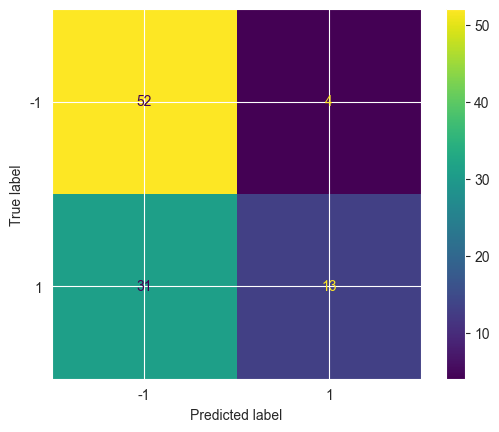

In [544]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot()

plt.show()

### Calcul des métriques
Les métriques qui seront calculées sont :
- Balanced Error Rate
- Accuracy
- Precision
- Recall
- F1 Score
- AUC Score
- ROC Curve

Ces metriques on ete conseillees par les juges du challenge Arcene pour evaluer les performances des algorithmes de classification. (https://web.archive.org/web/20130503080434/http://www.nipsfsc.ecs.soton.ac.uk/evaluation)
Pour plus d'informations sur ces métriques, veuillez consulter ce lien : https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

In [545]:
TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

BER = 1 - (1/2 * ((TP / (TP + FN)) + (TN / (TN + FP))))

precision = metrics.precision_score(arcene_valid_labels, predictions, average='macro')

recall = metrics.recall_score(arcene_valid_labels, predictions, average='macro')

f1_score = metrics.f1_score(arcene_valid_labels, predictions, average='macro')

accuracy = metrics.accuracy_score(arcene_valid_labels, predictions)

auc_score = metrics.roc_auc_score(arcene_valid_labels, predictions)

print('Balanced Error Rate: ', BER)
print('Accuracy:            ', accuracy)
print('Precision:           ', precision)
print('Recall:              ', recall)
print('F1 Score:            ', f1_score)
print('AUC Score:           ', auc_score)

Balanced Error Rate:  0.30439404677533666
Accuracy:             0.65
Precision:            0.6956059532246633
Recall:               0.612012987012987
F1 Score:             0.5872154735228211
AUC Score:            0.612012987012987


##### Courbe ROC:

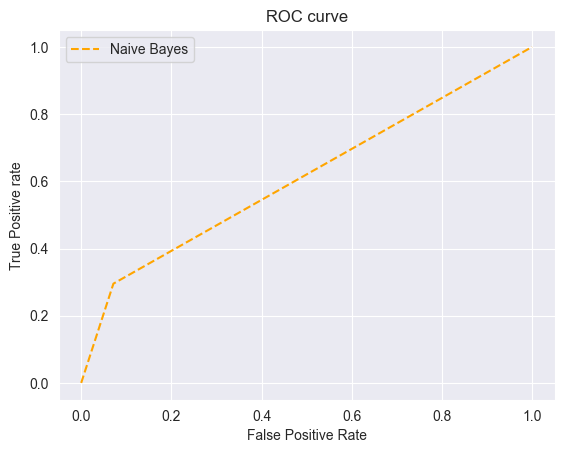

In [546]:
fpr, tpr, thresh = metrics.roc_curve(arcene_valid_labels, predictions, pos_label=1)

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Naive Bayes')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

Predire les classes des donnees de test:

In [547]:
test_pred = xgb.predict(arcene_test_filtered)

pred_len = len(test_pred)

test_pred = test_pred.reshape(pred_len, 1)

test_pred

array([[0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

### Visualisation des classes predites

   0  count
0  0    534
1  1    166


<Axes: xlabel='0', ylabel='count'>

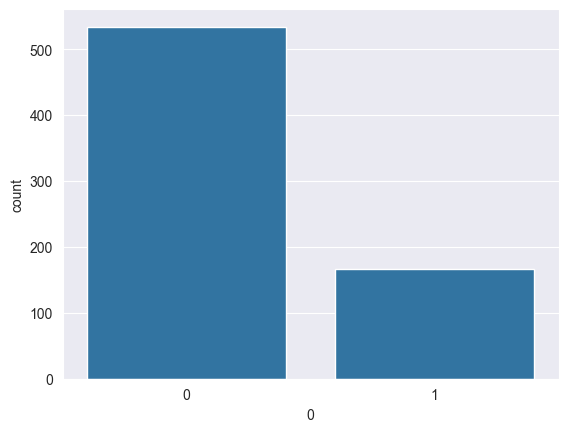

In [548]:
test_pred = pd.DataFrame(test_pred)

yy = test_pred.value_counts().reset_index()
print(yy)
sns.barplot(x=0, y='count', data=yy)

# Implementation de l'algorithme Extreme Gradient Boosting (XGBoost) avec la bibliotheque sklearn

In [549]:
xgbb = ExGB.XGBClassifier()

xgbb.fit(arcene_train_filtered, arcene_train_labels)

y_pred = xgbb.predict(arcene_valid_filtered)

pred_len = len(y_pred)

y_pred = y_pred.reshape(pred_len, 1)

print("Number of mislabeled points out of a total %d points : %d" % (arcene_valid.shape[0], (arcene_valid_labels != y_pred).sum()))

Number of mislabeled points out of a total 100 points : 40


C:\Users\legion\AppData\Local\Temp\ipykernel_9732\2617077726.py:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print("Number of mislabeled points out of a total %d points : %d" % (arcene_valid.shape[0], (arcene_valid_labels != y_pred).sum()))


### Matrice de confusion

In [550]:
cm_with_sklearn = metrics.confusion_matrix(arcene_valid_labels, y_pred)

cm_with_sklearn

array([[39, 17],
       [23, 21]], dtype=int64)

### Visualisation de la matrice de confusion

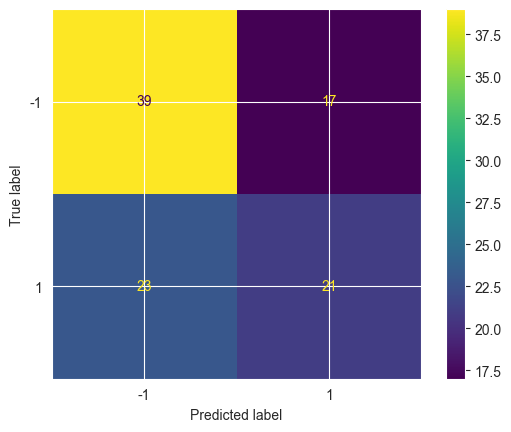

In [551]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_with_sklearn, display_labels=[-1, 1])
disp.plot()

plt.show()

### Calcul des métriques

In [552]:
TP_with_sklearn = cm_with_sklearn[0][0]
FP_with_sklearn = cm_with_sklearn[0][1]
FN_with_sklearn = cm_with_sklearn[1][0]
TN_with_sklearn = cm_with_sklearn[1][1]

BER_with_sklearn = 1 - (1/2 * ((TP_with_sklearn / (TP_with_sklearn + FN_with_sklearn)) + (TN_with_sklearn / (TN_with_sklearn + FP_with_sklearn))))

precision_with_sklearn = metrics.precision_score(arcene_valid_labels, y_pred, average='macro')

recall_with_sklearn = metrics.recall_score(arcene_valid_labels, y_pred, average='macro')

f1_score_with_sklearn = metrics.f1_score(arcene_valid_labels, y_pred, average='macro')

accuracy_with_sklearn = metrics.accuracy_score(arcene_valid_labels, y_pred)

auc_score_with_sklearn = metrics.roc_auc_score(arcene_valid_labels, y_pred)

print('Balanced Error Rate: ', BER_with_sklearn)
print('Accuracy:            ', accuracy_with_sklearn)
print('Precision:           ', precision_with_sklearn)
print('Recall:              ', recall_with_sklearn)
print('F1 Score:            ', f1_score_with_sklearn)
print('AUC Score:           ', auc_score_with_sklearn)

Balanced Error Rate:  0.4091680814940577
Accuracy:             0.6
Precision:            0.5908319185059423
Recall:               0.5868506493506493
F1 Score:             0.586606035551881
AUC Score:            0.5868506493506492


##### Courbe ROC:

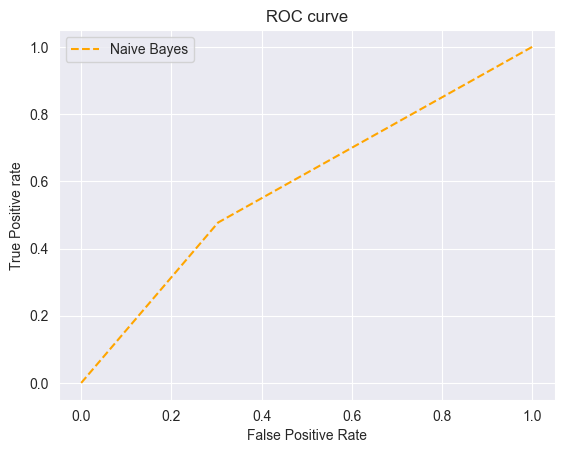

In [553]:
fpr_with_sklearn, tpr_with_sklearn, thresh_with_sklearn = metrics.roc_curve(arcene_valid_labels, y_pred, pos_label=1)

# plot roc curves
plt.plot(fpr_with_sklearn, tpr_with_sklearn, linestyle='--',color='orange', label='Naive Bayes')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show()

### Visualisation des classes predites

In [554]:
arcene_test_filtered_serie = arcene_test_filtered.squeeze()

test_pred_with_sklearn = xgbb.predict(arcene_test_filtered_serie)

   0  count
0  0    432
1  1    268


<Axes: xlabel='0', ylabel='count'>

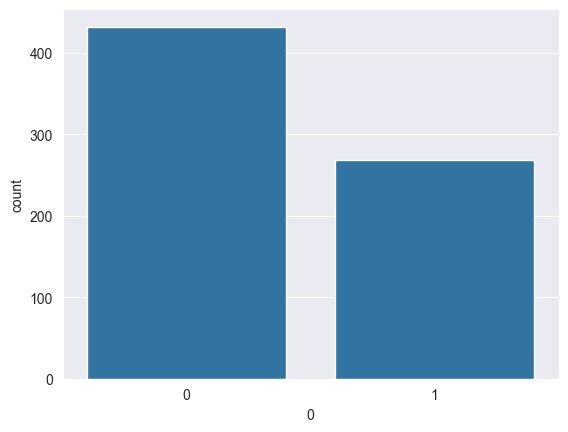

In [555]:
test_pred_with_sklearn = pd.DataFrame(test_pred_with_sklearn)

yy_with_sklearn = test_pred_with_sklearn.value_counts().reset_index()
print(yy_with_sklearn)
sns.barplot(x=0, y='count', data=yy_with_sklearn)

# **Conclusion:**
En comparant les resultats obtenus avec notre algorithme avec ceux obtenus avec l'algorithme Naive Bayes de sklearn, on remarque que notre algorithme donne de meilleurs resultats.

Mais en comparant les resultats obtenus avec notre algorithme avec ceux obtenus avec l'algorithme Extreme Gradient Boosting (XGBoost) de sklearn, on remarque que les resultats sont presque les memes.

Ainsi, quand on compare l'algorithme Extreme Gradient Boosting (XGBoost) et l'algorithme Naive Bayes, on remarque que l'algorithme Naive Bayes donne de meilleurs resultats.

# References:
https://arxiv.org/pdf/1603.02754.pdf \
https://xgboost.readthedocs.io/en/stable/tutorials/model.html \
https://medium.com/analytics-vidhya/what-makes-xgboost-so-extreme-e1544a4433bb \
https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/ \
https://www.youtube.com/user/joshstarmer/videos
https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/ \
https://cengiz.me/posts/extreme-gradient-boosting/ \
https://www.nvidia.com/en-us/glossary/data-science/xgboost/ \
https://www.kaggle.com/ronitf/heart-disease-uci \
https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c \
https://www.ibm.com/topics/naive-bayes#:~:text=the%20next%20step-,Na%C3%AFve%20Bayes%20classifiers,a%20given%20class%20or%20category. \
https://www.kaggle.com/code/ar2017/basics-of-feature-selection-with-python \ 
https://www.kaggle.com/code/bbloggsbott/feature-selection-correlation-and-p-value \ 
https://papers.nips.cc/paper_files/paper/2004/file/5e751896e527c862bf67251a474b3819-Paper.pdf \
https://web.archive.org/web/20130512034606/http://www.nipsfsc.ecs.soton.ac.uk/datasets \